In [13]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
%autoreload 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

import utilities as ut

import xgboost as xgb
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score, RepeatedKFold, GridSearchCV

color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

In [15]:
from featurewiz import FeatureWiz

# Create train data


In [6]:
# Read and structure all the parquet files in the data folder
data_list = ut.read_data()

In [7]:
# Create a data processor object
Data = ut.DataProcessor(data_list)

In [8]:
# Create the formatted dataframe
df = Data.create_train_data()

<Axes: xlabel='date_forecast'>

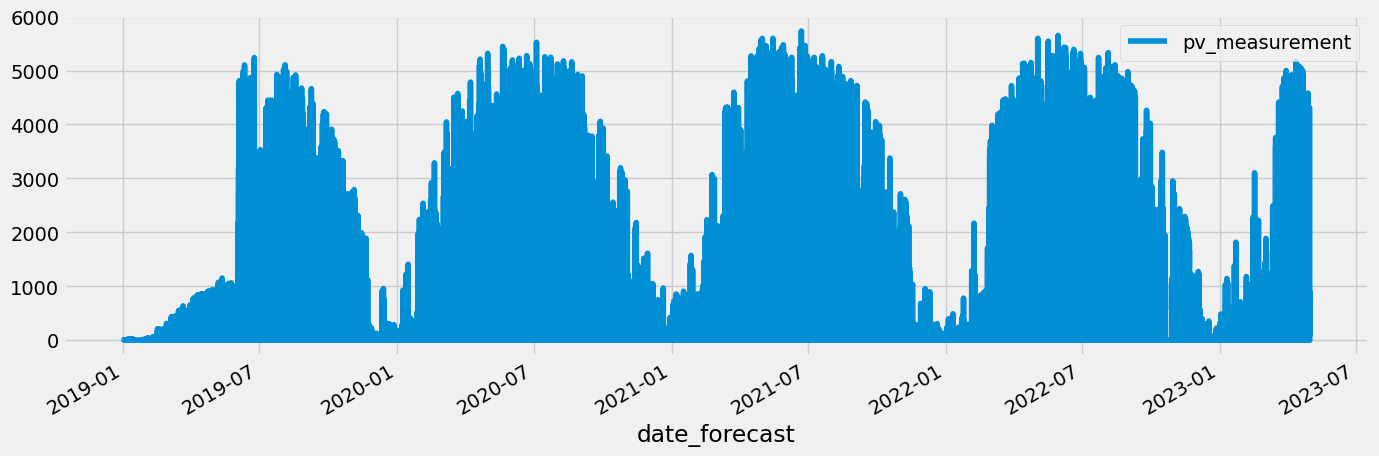

In [9]:
# plot db features column pv_measurement against the index iof the dataframe
df.plot(y='pv_measurement', figsize=(15, 5))

Seems like we are missing a lot of data in the first half of 2019

In [10]:
# slice df to only include from 2019-09-04 08:00:00 onwards (this is where we have data for all features)
df.sort_index(inplace=True)
df = df.loc['2019-09-04 08:00:00':]

<Axes: xlabel='date_forecast'>

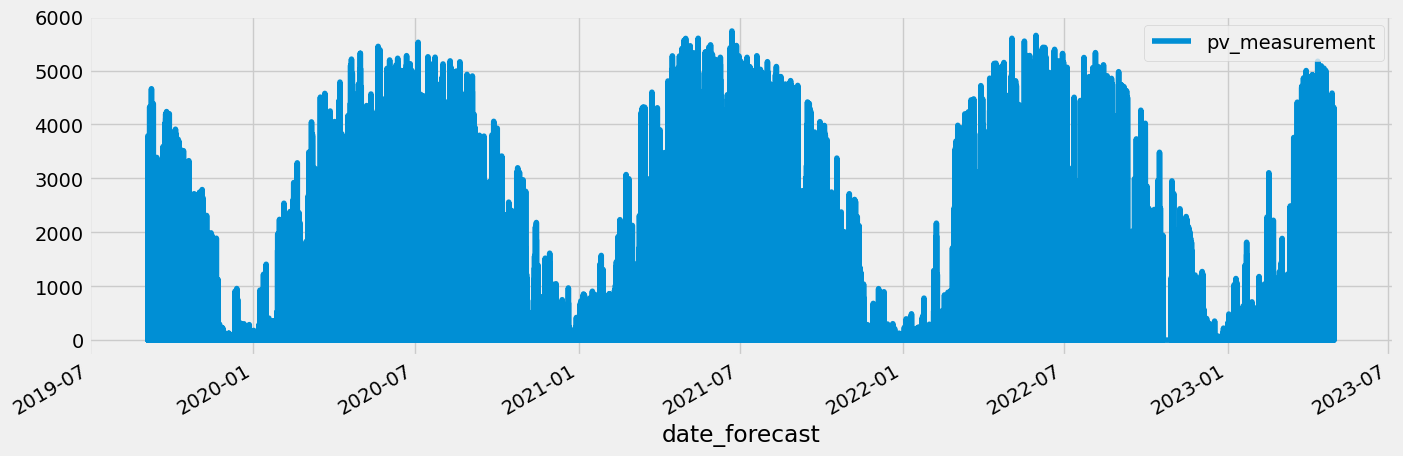

In [11]:
# createa add_lags function 
df.plot(y='pv_measurement', figsize=(15, 5))

## Feature Engineering

In [17]:
FEATURES = list(df.columns)
FEATURES.remove('pv_measurement')

TARGET = 'pv_measurement'

X_train = df[FEATURES]
y_train = df[TARGET]

X_test = Data.create_test_data()
X_test = X_test[FEATURES]

wiz = FeatureWiz(verbose=1)
        X_train_selected = wiz.fit_transform(X_train, y_train)
        X_test_selected = wiz.transform(X_test)
        wiz.features  ### provides a list of selected features ###            
        
############################################################################################
############       F A S T   F E A T U R E  E N G G    A N D    S E L E C T I O N ! ########
# Be judicious with featurewiz. Don't use it to create too many un-interpretable features! #
############################################################################################
featurewiz has selected 0.7 as the correlation limit. Change this limit to fit your needs...
Skipping feature engineering since no feature_engg input...
Skipping category encoding since no category encoders specified in input...
#### Single_Label Regression problem ####
    Loaded train data. Shape = (84798, 54)
    Some column names had special characters which were removed...
#### Single_Label Re

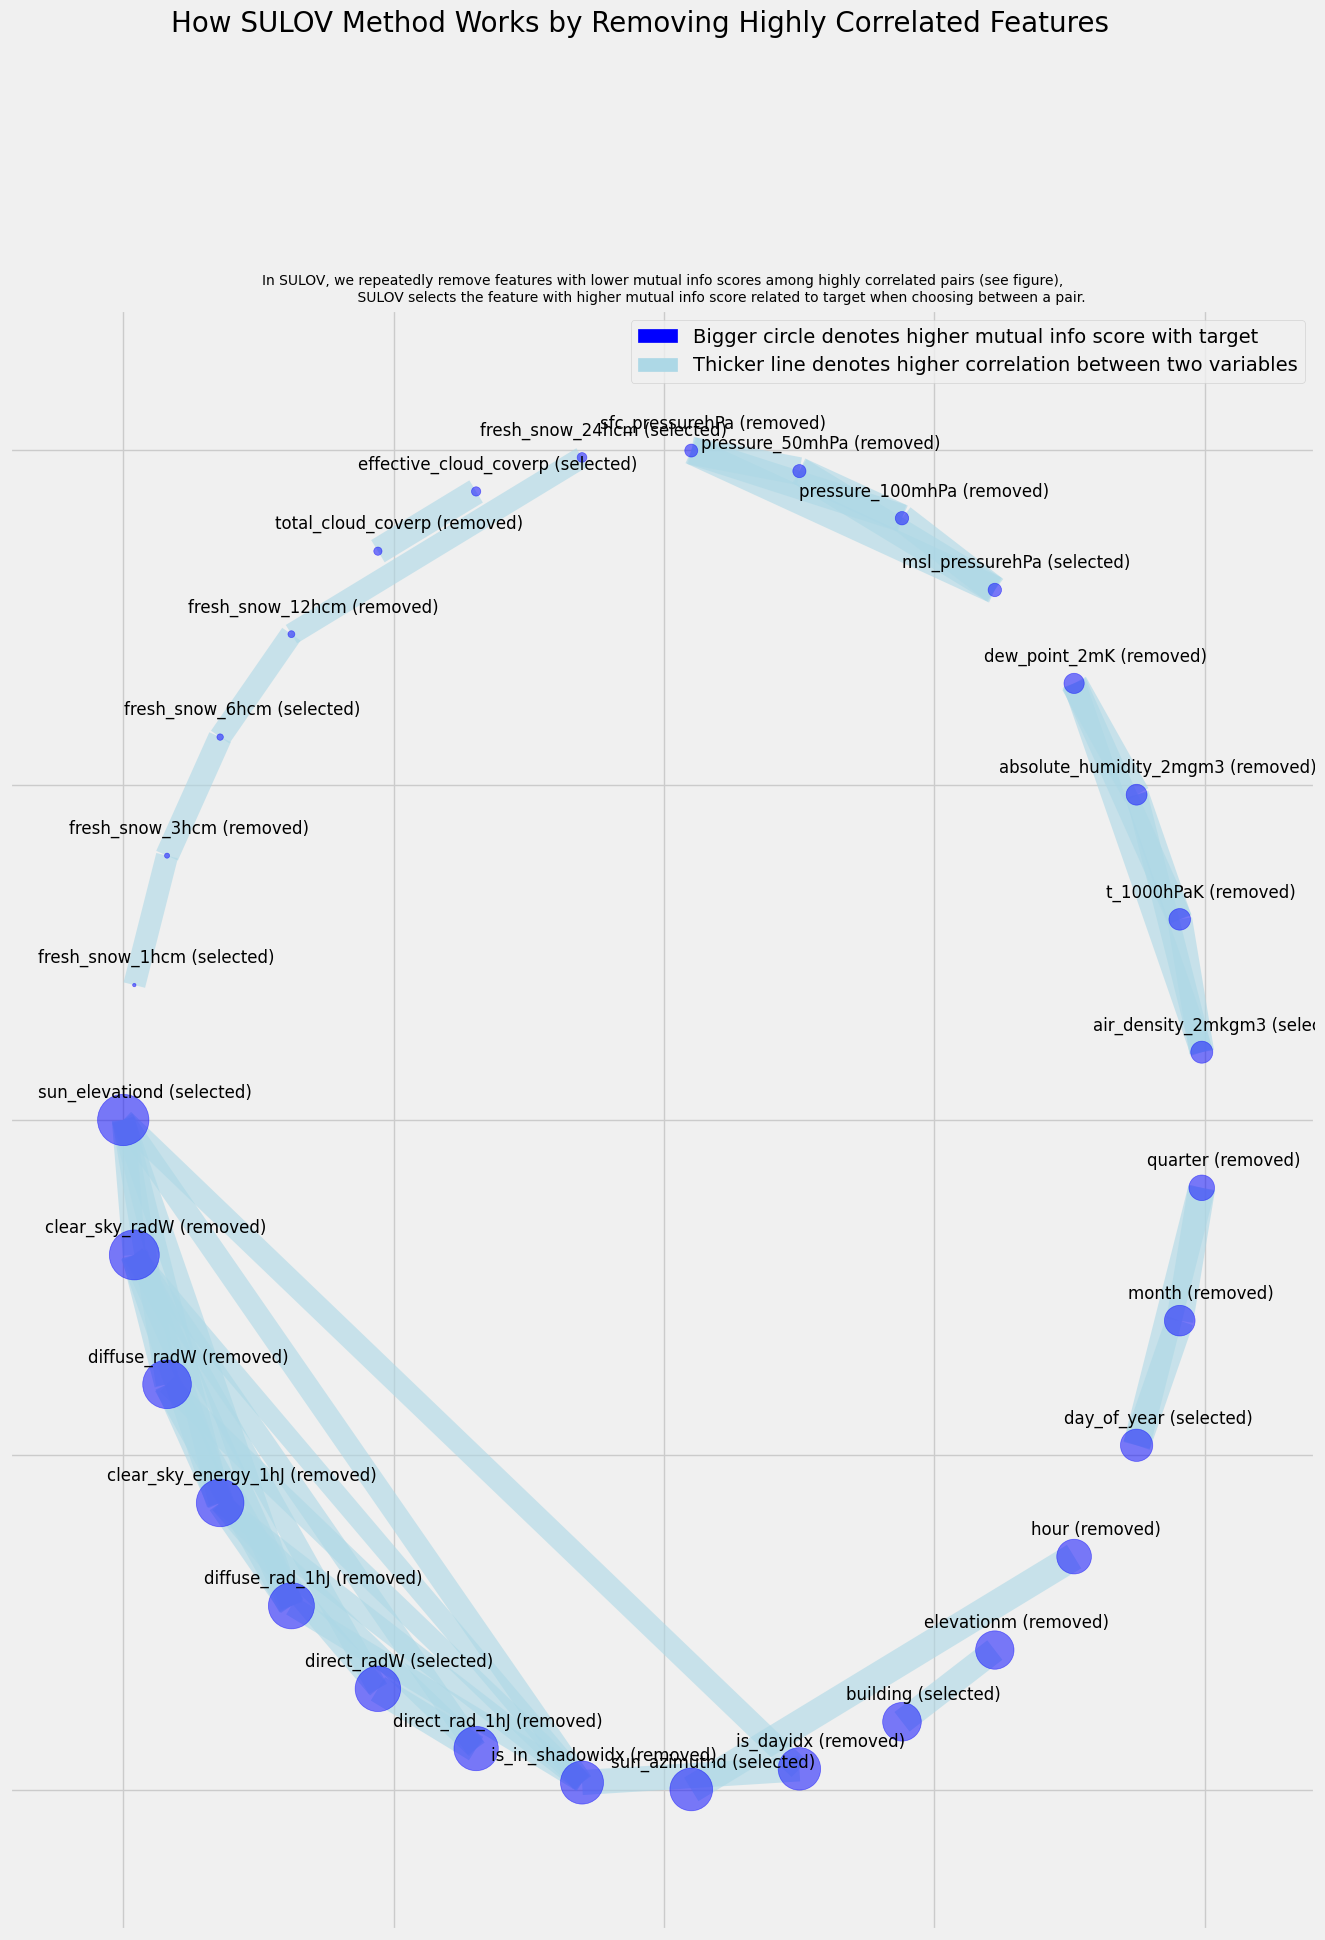

Time taken for SULOV method = 26 seconds
    Adding 0 categorical variables to reduced numeric variables  of 31
Finally 31 vars selected after SULOV
Converting all features to numeric before sending to XGBoost...
#######################################################################################
#####    R E C U R S I V E   X G B O O S T : F E A T U R E   S E L E C T I O N  #######
#######################################################################################
    using regular XGBoost
    Taking top 10 features per iteration...
    XGBoost version using 1.7.6 as tree method: hist
    Number of booster rounds = 100
        Selected: ['direct_radW', 'building', 'sun_elevationd', 'sun_azimuthd', 'day_of_year', 'air_density_2mkgm3', 'wind_speed_u_10mms', 'msl_pressurehPa', 'cloud_base_aglm', 'ceiling_height_aglm']
            Time taken for regular XGBoost feature selection = 6 seconds
        Selected: ['direct_radW', 'building', 'sun_elevationd', 'sun_azimuthd', 'day_of_year

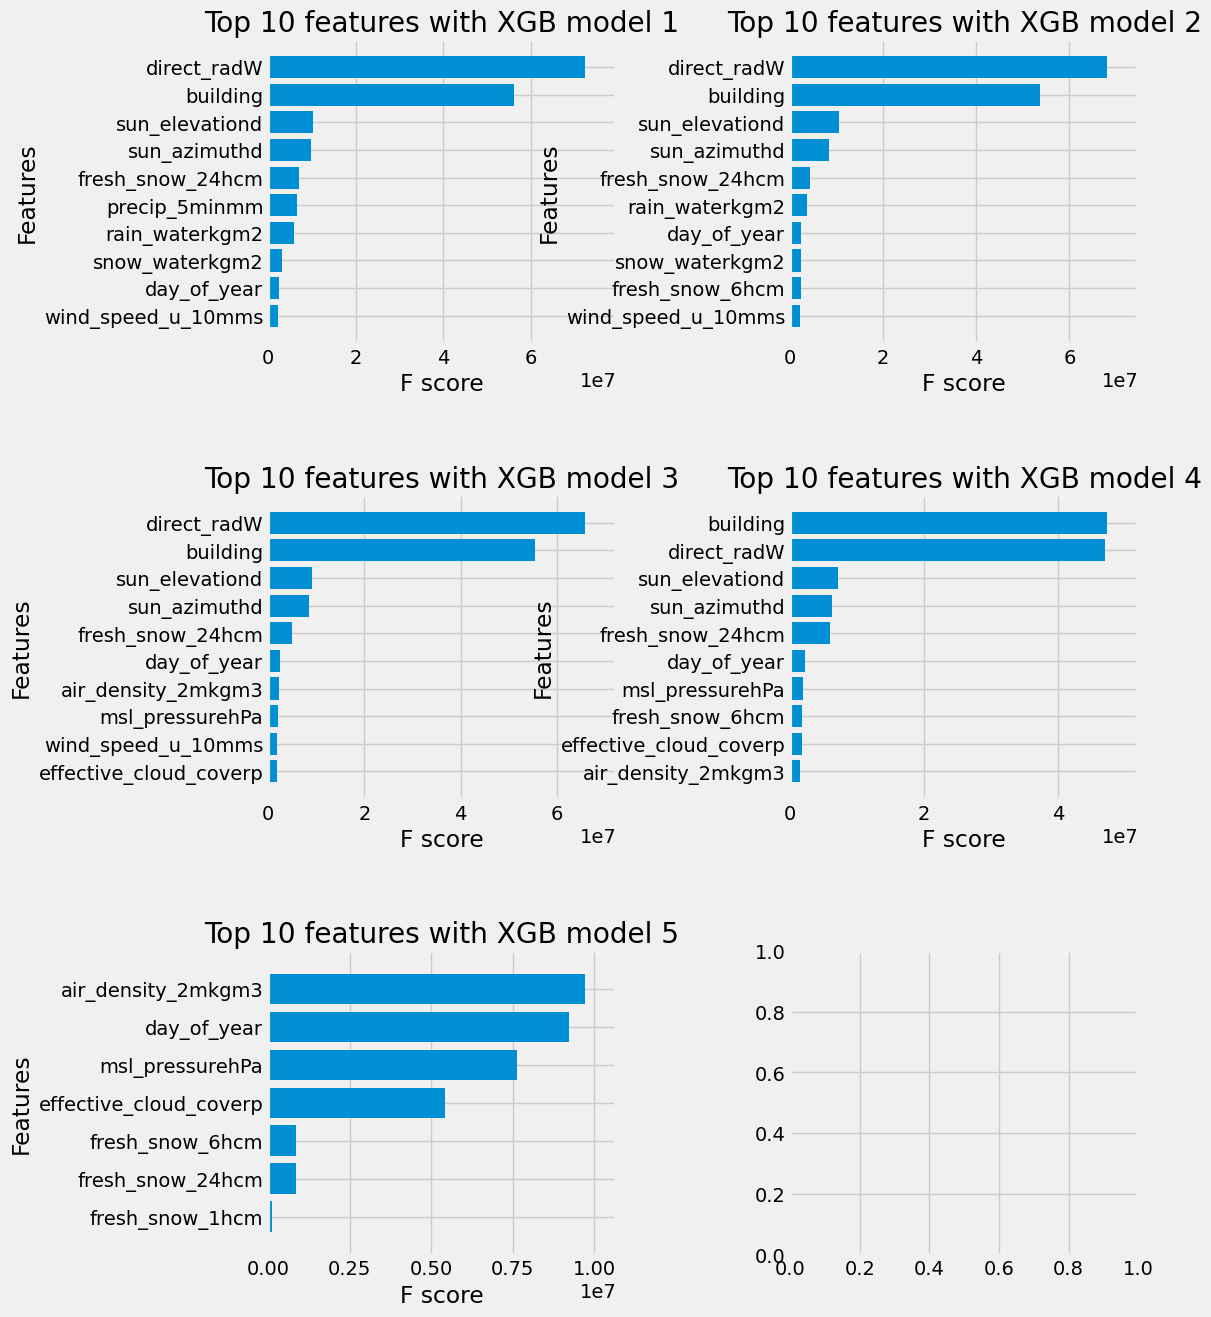

    Completed XGBoost feature selection in 1 seconds
#######################################################################################
#####          F E A T U R E   S E L E C T I O N   C O M P L E T E D            #######
#######################################################################################
Selected 19 important features:
['direct_radW', 'building', 'sun_elevationd', 'sun_azimuthd', 'day_of_year', 'air_density_2mkgm3', 'wind_speed_u_10mms', 'msl_pressurehPa', 'cloud_base_aglm', 'ceiling_height_aglm', 'visibilitym', 'relative_humidity_1000hPap', 'wind_speed_10mms', 'effective_cloud_coverp', 'day_of_month', 'year', 'fresh_snow_24hcm', 'fresh_snow_6hcm', 'fresh_snow_1hcm']
Total Time taken for featurewiz selection = 47 seconds
Output contains a list of 19 important features and a train dataframe
    Time taken to create entire pipeline = 47 second(s)


In [18]:
fwiz = FeatureWiz(corr_limit=0.70, feature_engg='', category_encoders='', dask_xgboost_flag=False, nrows=None, verbose=2)
X_train_selected = fwiz.fit_transform(X_train, y_train)
X_test_selected = fwiz.transform(X_test)
### get list of selected features ###
feats = fwiz.features  

In [22]:
X_train_selected = X_train_selected[feats]

## Train and fit model

In [26]:
# Various hyper-parameters to tune
xgb1 = xgb.XGBRFRegressor()
parameters = {'nthread':[4], #when use hyperthread, xgboost may become slower
              'learning_rate': [.03, 0.05, .07], #so called `eta` value
              'max_depth': [5, 6, 7],
              'min_child_weight': [1,4],
              'silent': [1],
              'subsample': [0.7],
              'colsample_bytree': [0.7],
              'n_estimators': [500]}

xgb_grid = GridSearchCV(xgb1,
                        parameters,
                        cv = 2,
                        n_jobs = 5,
                        verbose=True)

xgb_grid.fit(X_train_selected,
         y_train)

print(xgb_grid.best_score_)
print(xgb_grid.best_params_)

Fitting 2 folds for each of 18 candidates, totalling 36 fits


KeyboardInterrupt: 

In [40]:
# define model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(best_xgb_mode, X_train, y_train, scoring='neg_mean_absolute_error', cv=cv)

In [42]:
scores = abs(scores)
print('Mean MAE: %.3f (%.3f)' % (scores.mean(), scores.std()) )

Mean MAE: 90.007 (2.005)


In [48]:
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [49]:
fi = pd.DataFrame(data=model.feature_importances_,
                  index=model.feature_names_in_,
                  columns=['importance'])

<Axes: >

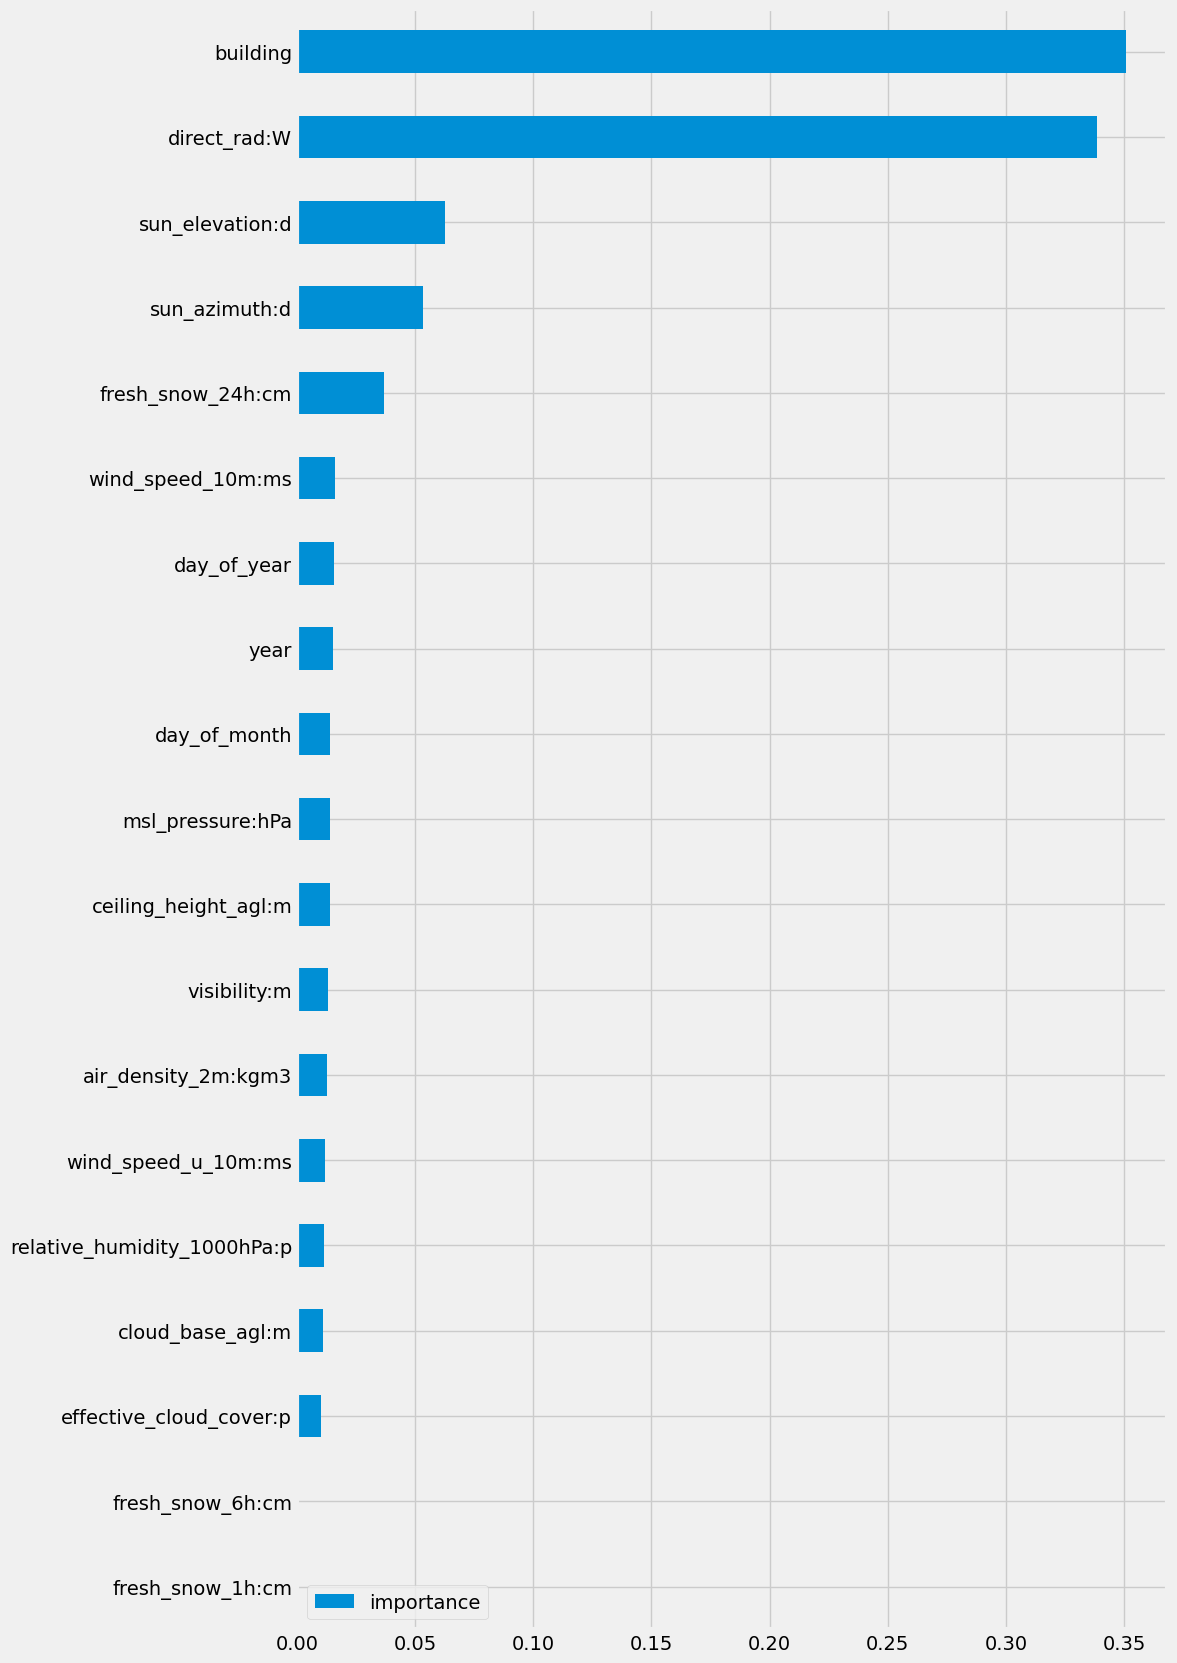

In [50]:
fi.sort_values(by='importance').plot(kind='barh', figsize=(10,20))

### Make prediction

In [72]:
X_test = Data.create_test_data()

In [73]:
X_test_adjusted = X_test[FEATURES]

In [74]:
result = model.predict(X_test_adjusted)

In [77]:
test = ut.create_results_dataframe(X_test, result)

In [79]:
test

,hour,day_of_week,quarter,month,year,day_of_year,day_of_month,building,pv_prediction
date_forecast,,,,,,,,,
2023-05-01 00:00:00,0,0,2,5,2023,121,1,0,-9.280357
2023-05-01 00:00:00,0,0,2,5,2023,121,1,1,-5.711543
2023-05-01 00:00:00,0,0,2,5,2023,121,1,2,-13.358723
2023-05-01 00:15:00,0,0,2,5,2023,121,1,0,-9.280357
2023-05-01 00:15:00,0,0,2,5,2023,121,1,1,-5.711543
...,...,...,...,...,...,...,...,...,...
2023-07-03 23:30:00,23,0,3,7,2023,184,3,0,-21.467056
2023-07-03 23:30:00,23,0,3,7,2023,184,3,1,5.196850
2023-07-03 23:45:00,23,0,3,7,2023,184,3,1,11.942842
